In [2]:
%matplotlib inline

import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from collections import defaultdict
from collections import OrderedDict

In [3]:
f = open('prediction/all_boxscores_2000_2017.json')
boxscore_data = json.load(f)

In [4]:
boxscore_data_ordered_by_key = OrderedDict(sorted(boxscore_data.items()))

In [5]:
# build running averages of stats in a season for a team
# team-ID -> season -> team's game ID -> stat_type -> average (inclusive of current game)
team_boxscore_rolling_averages = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

boxscore_categories = ['boxscoretraditionalv2', 'boxscoreadvancedv2', 'boxscoremiscv2', 'boxscorescoringv2',
                       'boxscoreusagev2', 'boxscorefourfactorsv2', 'boxscoreplayertrackv2', 'hustlestatsboxscore',
                       'boxscoresummaryv2']
supported_boxscore_categories = ['boxscoretraditionalv2', 'boxscoreadvancedv2']

def prune_team_stats(team_stats):
  pruned_team_stats = []
  stat_name_index_tuples = [
    ('FGM', 6),
    ('FGA', 7),
    ('FG_PCT', 8),
    ('FG3M', 9),
    ('FG3A', 10),
    ('FG3_PCT', 11),
    ('FTM', 12),
    ('FTA', 13),
    ('FT_PCT', 14),
    ('OREB', 15),
    ('DREB', 16),
    ('REB', 17),
    ('AST', 18),
    ('STL', 19),
    ('BLK', 20),
    ('TO', 21),
    ('PF', 22),
    ('PTS', 23),
    ('PLUS_MINUS', 24)
  ]
  
  for stat_name_index_tuple in stat_name_index_tuples:
    pruned_team_stats.append(team_stats[stat_name_index_tuple[1]])
  
  return np.asarray(pruned_team_stats)

def prune_advanced_team_stats(advanced_team_stats):
  pruned_advanced_team_stats = []
  stat_name_index_tuples = [
    ('OFF_RATING', 6),
    ('DEF_RATING', 7),
    ('NET_RATING', 8),
    ('AST_PCT', 9),
    ('AST_TOV', 10),
    ('AST_RATIO', 11),
    ('OREB_PCT', 12),
    ('DREB_PCT', 13),
    ('REB_PCT', 14),
    ('TM_TOV_PCT', 15),
    ('EFG_PCT', 16),
    ('TS_PCT', 17),
    ('USG_PCT', 18),
    ('PACE', 19),
    ('PIE', 20)
  ]
  
  for stat_name_index_tuple in stat_name_index_tuples:
    pruned_advanced_team_stats.append(advanced_team_stats[stat_name_index_tuple[1]])
  
  return np.asarray(pruned_advanced_team_stats)

def prune_starter_bench_stats(team_starter_bench_stats):
  pruned_team_starter_bench_stats = []
  stat_name_index_tuples = [
    ('FGM', 7),
    ('FGA', 8),
    ('FG_PCT', 9),
    ('FG3M', 10),
    ('FG3A', 11),
    ('FG3_PCT', 12),
    ('FTM', 13),
    ('FTA', 14),
    ('FT_PCT', 15),
    ('OREB', 16),
    ('DREB', 17),
    ('REB', 18),
    ('AST', 19),
    ('STL', 20),
    ('BLK', 21),
    ('TO', 22),
    ('PF', 23),
    ('PTS', 24),
  ]
  
  for stat_name_index_tuple in stat_name_index_tuples:
    pruned_team_starter_bench_stats.append(team_starter_bench_stats[stat_name_index_tuple[1]])
  
  return np.asarray(pruned_team_starter_bench_stats)

# maintains state about how many games were played by a team in a season, reset every season
# TEAM_ID -> num games played
team_games_played_dict = defaultdict(lambda: 1)
prev_game_id_dict = defaultdict(str)

# team_id -> game_id -> previous game ID
game_sequence_dict = defaultdict(lambda: defaultdict(str))

game_ids_by_season = defaultdict(list)

home_away_team_indices_by_game_id = {}

prev_game_num = None
prev_game_id = None
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  game_num = game_id[-4:]
  season = game_id[3:5]
  if game_num == '0001':
    team_games_played_dict = defaultdict(lambda: 1)
    prev_game_id_dict = defaultdict(str)
  if 'resultSets' in boxscore_data[json_file_name]['boxscoresummaryv2']:
    boxscore_summary_data = boxscore_data[json_file_name]['boxscoresummaryv2']['resultSets'][0]['rowSet'][0]
  else:
    continue
  game_ids_by_season[season].append(game_id)
  home_team_id = boxscore_summary_data[6]
  away_team_id = boxscore_summary_data[7]
  away_team_idx = None
  home_team_idx = None
  for boxscore_category in supported_boxscore_categories:
    category_data = boxscore_data[json_file_name][boxscore_category]
    if 'resultSets' in category_data:
      data = category_data['resultSets']
      if len(data[1]['rowSet']) == 0:
        continue
    if boxscore_category == 'boxscoretraditionalv2':
      if data[1]['rowSet'][0][1] == home_team_id:
        away_team_idx = 1
        home_team_idx = 0
      else:
        away_team_idx = 0
        home_team_idx = 1
      home_away_team_indices_by_game_id[game_id] = (away_team_idx, home_team_idx)
      team_stats_away = data[1]['rowSet'][away_team_idx]
      team_stats_home = data[1]['rowSet'][home_team_idx]
      pruned_team_stats_away_features = prune_team_stats(team_stats_away)
      pruned_team_stats_home_features = prune_team_stats(team_stats_home)
      team_starter_stats_away = data[2]['rowSet'][0]
      team_bench_stats_away = data[2]['rowSet'][1]
      team_starter_stats_home = data[2]['rowSet'][2]
      team_bench_stats_home = data[2]['rowSet'][3]
      pruned_starter_stats_away = prune_starter_bench_stats(team_starter_stats_away)
      pruned_bench_stats_away = prune_starter_bench_stats(team_bench_stats_away)
      pruned_starter_stats_home = prune_starter_bench_stats(team_starter_stats_home)
      pruned_bench_stats_home = prune_starter_bench_stats(team_bench_stats_away)
      
      if team_games_played_dict[away_team_id] == 1:
        team_boxscore_rolling_averages[away_team_id][season][game_id]['team_stats'] = pruned_team_stats_away_features
      else:
        prev_game_num = team_games_played_dict[away_team_id] - 1
        curr_game_num = team_games_played_dict[away_team_id]
        prev_game_id = prev_game_id_dict[away_team_id]
        game_sequence_dict[away_team_id][game_id] = prev_game_id
        prev_away_team_stats = team_boxscore_rolling_averages[away_team_id][season][prev_game_id]['team_stats']
        team_boxscore_rolling_averages[away_team_id][season][game_id]['team_stats'] = \
          prev_away_team_stats + \
          (pruned_team_stats_away_features - prev_away_team_stats)/curr_game_num

      if team_games_played_dict[home_team_id] == 1:
        team_boxscore_rolling_averages[home_team_id][season][game_id]['team_stats'] = pruned_team_stats_home_features
      else:
        prev_game_num = team_games_played_dict[home_team_id] - 1
        curr_game_num = team_games_played_dict[home_team_id]
        prev_game_id = prev_game_id_dict[home_team_id]
        game_sequence_dict[home_team_id][game_id] = prev_game_id
        prev_home_team_stats = team_boxscore_rolling_averages[home_team_id][season][prev_game_id]['team_stats']
        team_boxscore_rolling_averages[home_team_id][season][game_id]['team_stats'] = \
          prev_home_team_stats + \
          (pruned_team_stats_home_features - prev_home_team_stats)/curr_game_num
    elif boxscore_category == 'boxscoreadvancedv2':
      advanced_team_stats_away = data[1]['rowSet'][away_team_idx]
      advanced_team_stats_home = data[1]['rowSet'][home_team_idx]
      pruned_advanced_team_stats_away_features = prune_advanced_team_stats(advanced_team_stats_away)
      pruned_advanced_team_stats_home_features = prune_advanced_team_stats(advanced_team_stats_home)
      
      if team_games_played_dict[away_team_id] == 1:
        team_boxscore_rolling_averages[away_team_id][season][game_id]['advanced_team_stats'] = pruned_advanced_team_stats_away_features
      else:
        prev_game_num = team_games_played_dict[away_team_id] - 1
        curr_game_num = team_games_played_dict[away_team_id]
        prev_game_id = prev_game_id_dict[away_team_id]
        game_sequence_dict[away_team_id][game_id] = prev_game_id
        prev_away_advanced_team_stats = team_boxscore_rolling_averages[away_team_id][season][prev_game_id]['advanced_team_stats']
        team_boxscore_rolling_averages[away_team_id][season][game_id]['advanced_team_stats'] = \
          prev_away_advanced_team_stats + \
          (pruned_advanced_team_stats_away_features - prev_away_advanced_team_stats)/curr_game_num

      if team_games_played_dict[home_team_id] == 1:
        team_boxscore_rolling_averages[home_team_id][season][game_id]['advanced_team_stats'] = pruned_advanced_team_stats_home_features
      else:
        prev_game_num = team_games_played_dict[home_team_id] - 1
        curr_game_num = team_games_played_dict[home_team_id]
        prev_game_id = prev_game_id_dict[home_team_id]
        game_sequence_dict[home_team_id][game_id] = prev_game_id
        prev_home_advanced_team_stats = team_boxscore_rolling_averages[home_team_id][season][prev_game_id]['advanced_team_stats']
        team_boxscore_rolling_averages[home_team_id][season][game_id]['advanced_team_stats'] = \
          prev_home_advanced_team_stats + \
          (pruned_advanced_team_stats_home_features - prev_home_advanced_team_stats)/curr_game_num
    else:
      # ignore other categories for now
      break
      
  prev_game_id_dict[away_team_id] = game_id
  team_games_played_dict[away_team_id] += 1
  prev_game_id_dict[home_team_id] = game_id
  team_games_played_dict[home_team_id] += 1

In [6]:
# cumulative timeseries for the OKC Thunder in the 2016-17 season
okc_ts = team_boxscore_rolling_averages[1610612760]['16']
# rolling averages of stats over entire season (last element of timeseries)
print okc_ts['0021601225']['team_stats']
# FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUSMINUS
print okc_ts['0021601225']['advanced_team_stats']

[  39.47560976   87.41463415    0.45214634    8.43902439   25.80487805
    0.32653659   19.20731707   25.76829268    0.74769512   12.2195122
   34.40243902   46.62195122   20.98780488    7.90243902    4.98780488
   14.63414634   20.91463415  106.59756098    0.75609756]
[ 105.10609756  105.23902439   -0.13414634    0.5297439     1.47329268
   15.49390244    0.27928049    0.79246341    0.53479268   14.75363415
    0.50069512    0.54067073    0.1992439   100.45231707    0.4992561 ]


In [7]:
# create labels for training/testing
# delta is from the away team perspective (e.g if the away team loses by 5, delta = -5)
game_id_score_delta_dict = {}
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  category_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  if 'resultSets' in category_data:
    data = category_data['resultSets']
    # first team in list is away, second is home
    if len(data[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_stats = data[1]['rowSet'][away_team_idx]
    away_team_plus_minus = away_team_stats[24]
    game_id_score_delta_dict[game_id] = away_team_plus_minus

In [8]:
# OKC beats Denver by 1 point in the final game of the 2016-17 season
game_id_score_delta_dict['0021601198']

1.0

In [9]:
# assemble feature vectors
# away team features, home team features
feature_vectors = []
labels = []
game_ids_for_feat_vectors = []
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  feature_vector = []
  game_id = json_file_name.split('.')[0]
  game_num = game_id[-4:]
  season = game_id[3:5]
  
  category_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  if 'resultSets' in category_data:
    data = category_data['resultSets']
    if len(data[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_id = data[1]['rowSet'][away_team_idx][1]
    home_team_id = data[1]['rowSet'][home_team_idx][1]
    
    if game_sequence_dict[away_team_id][game_id] == "" or game_sequence_dict[home_team_id][game_id] == "":
      continue
    # get previous game averages for both teams
    prev_game_id_away = game_sequence_dict[away_team_id][game_id]
    prev_game_id_home = game_sequence_dict[home_team_id][game_id]
    away_stats_avg = team_boxscore_rolling_averages[away_team_id][season][prev_game_id_away]['team_stats']
    home_stats_avg = team_boxscore_rolling_averages[home_team_id][season][prev_game_id_home]['team_stats']
    away_advanced_team_stats_avg = team_boxscore_rolling_averages[away_team_id][season][prev_game_id_away]['advanced_team_stats']
    home_advanced_team_stats_avg = team_boxscore_rolling_averages[home_team_id][season][prev_game_id_home]['advanced_team_stats']
    game_ids_for_feat_vectors.append(game_id)
    away_features = np.append(away_stats_avg, away_advanced_team_stats_avg)
    home_features = np.append(home_stats_avg, home_advanced_team_stats_avg)
    feature_vectors.append(np.append(away_features, home_features))
    labels.append(game_id_score_delta_dict[game_id])

feature_matrix = np.asarray(feature_vectors)
labels = np.asarray(labels)

In [10]:
feature_matrix.shape

(20211, 68)

In [11]:
labels.shape

(20211,)

In [12]:
print 'Feature vector and label for Game: 0020000015'
print feature_matrix[0]
print labels[0]

Feature vector and label for Game: 0020000015
[  35.      93.       0.376    5.      17.       0.294   20.      31.
    0.645   20.      28.      48.      27.       7.       7.      15.      21.
   95.      -9.      93.5    102.      -8.6      0.771    1.8     18.2
    0.37     0.718    0.516   14.758    0.403    0.445    0.2    101.78
    0.446   38.      66.       0.576    3.       8.       0.375   22.      30.
    0.733    8.      29.      37.      27.      10.       5.      13.      24.
  101.      29.     118.5     81.3     37.2      0.711    1.93    22.5
    0.258    0.674    0.5     16.432    0.598    0.638    0.198   86.88
    0.819]
-6.0


In [13]:
# linear regression model
regr = linear_model.LinearRegression()
regr.fit(feature_matrix, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
regr.predict(feature_matrix[0].reshape(1, -1))

array([-21.07478137])

In [15]:
# import and clean up spread data
bet_data_2016_2017 = pickle.load(open('data_retrieval/spread_data_nowgoal/bet_info_2016_2017_full_corrected.pkl', 'rb'))

def fix_game(game):
  fixes = {
    'Milwaukee': 'Bucks',
    'Trail': 'Trail Blazers',
    'Trailblazers': 'Trail Blazers',
    'Trail Blaze': 'Trail Blazers',
    'sac': 'Kings'
  }
  for key in ('home', 'away'):
    if key in game and game[key] in fixes:
      game[key] = fixes[game[key]]

bet_info = []
for day_str, games in bet_data_2016_2017.iteritems():
  for game in games:
    fix_game(game)
    bet_info.append({
      'home': game['home'],
      'away': game['away'],
      'overunder': game['overunder'],
      'line': game['line'],
      'date': datetime.datetime.strptime(day_str, '%Y-%m-%d') - datetime.timedelta(days=1),
    })
    
bet_data_by_tuple_rep = {}
for bet_data in bet_info:
  tuple_rep = (bet_data['away'], bet_data['home'], bet_data['date'])
  bet_data_by_tuple_rep[tuple_rep] = bet_data

In [16]:
# mapping between game ID and (home_team, away_team, datetime)
TEAM_ID_TO_NAME = {
  1610612737: 'Hawks',
  1610612738: 'Celtics',
  1610612751: 'Nets',
  1610612766: 'Hornets',
  1610612741: 'Bulls',
  1610612739: 'Cavaliers',
  1610612742: 'Mavericks',
  1610612743: 'Nuggets',
  1610612765: 'Pistons',
  1610612744: 'Warriors',
  1610612745: 'Rockets',
  1610612754: 'Pacers',
  1610612746: 'Clippers',
  1610612747: 'Lakers',
  1610612763: 'Grizzlies',
  1610612748: 'Heat',
  1610612749: 'Bucks',
  1610612750: 'Timberwolves',
  1610612740: 'Pelicans',
  1610612752: 'Knicks',
  1610612760: 'Thunder',
  1610612753: 'Magic',
  1610612755: '76ers',
  1610612756: 'Suns',
  1610612757: 'Trail Blazers',
  1610612758: 'Kings',
  1610612759: 'Spurs',
  1610612761: 'Raptors',
  1610612762: 'Jazz',
  1610612764: 'Wizards', 
}

tuple_rep_by_game_id = {}
for json_file_name, data in boxscore_data_ordered_by_key.iteritems():
  game_id = json_file_name.split('.')[0]
  traditional_data = boxscore_data[json_file_name]['boxscoretraditionalv2']
  away_team_id = None
  home_team_id = None
  game_date = None
  if 'resultSets' in traditional_data:
    traditional_results = traditional_data['resultSets']
    # first team in list is away, second is home
    if len(traditional_results[1]['rowSet']) == 0:
      continue
    away_team_idx, home_team_idx = home_away_team_indices_by_game_id[game_id]
    away_team_id = traditional_results[1]['rowSet'][away_team_idx][1]
    home_team_id = traditional_results[1]['rowSet'][home_team_idx][1]
  else:
    continue
  boxscore_summary = boxscore_data[json_file_name]['boxscoresummaryv2']
  if 'resultSets' in boxscore_summary:
    summary_results = boxscore_summary['resultSets']
    if len(summary_results[0]['rowSet']) == 0:
      continue
    game_date = datetime.datetime.strptime(summary_results[0]['rowSet'][0][0].split('T')[0], '%Y-%m-%d')
  tuple_rep_by_game_id[game_id] = (TEAM_ID_TO_NAME[away_team_id], TEAM_ID_TO_NAME[home_team_id], game_date)

In [17]:
# map game IDs to spreads, game_ids from stats.nba.com should map 1:1 with spreads (1230 elements each)
game_ids_2016_2017 = game_ids_by_season['16']
spreads_for_2016_2017 = {}
for game_id in game_ids_2016_2017:
  tuple_rep = tuple_rep_by_game_id[game_id]
  spreads_for_2016_2017[game_id] = (bet_data_by_tuple_rep[tuple_rep])

In [18]:
# Evaluation
# As a preliminary evaluation run, train on 2000-2016, evaluate on 2016-2017 season
feature_vectors_for_2000_2016 = []
labels_for_2000_2016 = []
game_ids_2016_2017_feat_vectors = []
feature_vectors_for_2016_2017 = []
labels_for_2016_2017 = []

# collect only feature vectors/labels for the 2016 season for training
for idx, feature_vector in enumerate(feature_matrix):
  game_id = game_ids_for_feat_vectors[idx]
  game_season = game_id[3:5]
  if game_season == '16':
    feature_vectors_for_2016_2017.append(feature_vector)
    labels_for_2016_2017.append(labels[idx])
    game_ids_2016_2017_feat_vectors.append(game_id)
  else:
    feature_vectors_for_2000_2016.append(feature_vector)
    labels_for_2000_2016.append(labels[idx])

feature_matrix_for_2000_2016 = np.asarray(feature_vectors_for_2000_2016)
labels_for_2000_2016 = np.asarray(labels_for_2000_2016)
# linear regression model for 2000-2016 data
regr_2016_2017 = linear_model.LinearRegression()
regr_2016_2017.fit(feature_vectors_for_2000_2016, labels_for_2000_2016)

feature_matrix_for_2016_2017 = np.asarray(feature_vectors_for_2016_2017)
lin_regr_predictions = regr_2016_2017.predict(feature_vectors_for_2016_2017)
print 'Number of games where either or both teams are playing the first game of the season: {}'.format(
  len(game_ids_by_season['16']) - len(lin_regr_predictions))

print game_ids_2016_2017_feat_vectors[0]
print feature_matrix_for_2016_2017[0]
print labels_for_2016_2017[0]

print len(game_ids_2016_2017_feat_vectors)
print len(lin_regr_predictions)

def evaluate(n_games_in, predictions):
  wins = 0.
  losses = 0.
  bets_not_placed = 0
  bets_placed = 0
  for idx in range(n_games_in, len(predictions)):
    score_delta_prediction = predictions[idx]
    game_id = game_ids_2016_2017_feat_vectors[idx]
    spread_data = spreads_for_2016_2017[game_id]
    actual_score_delta = labels_for_2016_2017[idx]
    # need to multiply by -1 because positive predictions mean away team is favorite, but need to convert
    # to spread
    actual_score_delta = -1 * actual_score_delta
    score_delta_prediction = -1 * score_delta_prediction
    line = spread_data['line'] # will be in the format -7.5 if away team is favored to win by >=7.5
    # away team is favored
    # win the game by at least the line
    if line < 0 and score_delta_prediction < line:
      bets_placed += 1
      if actual_score_delta < line:
        wins += 1
      else:
        losses += 1
      continue
    if line < 0 and score_delta_prediction > line:
      bets_placed += 1
      if actual_score_delta > line:
        wins += 1
      else:
        losses += 1
      continue
    # away team is underdog
    # lose by less than the line or outright win
    if line > 0 and score_delta_prediction > line:
      bets_placed += 1
      if actual_score_delta > line:
        wins += 1
      else:
        losses += 1
      continue
    if line > 0 and score_delta_prediction < line:
      bets_placed += 1
      if actual_score_delta < line:
        wins += 1
      else:
        losses += 1
      continue
    bets_not_placed += 1
  print '{} games in'.format(n_games_in)
  print 'Win Percent: {}'.format(wins/bets_placed)
  print 'Loss Percent: {}'.format(losses/bets_placed)
  print 'Bets placed: {}'.format(bets_placed)
  print 'Bets not placed: {}'.format(bets_not_placed)

# feature_vector = away stats, home stats
# FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUSMINUS
# label = num points away team won/lost by
# predictions will be differential from away team perspective
# lines are also from away team perspective (negative line means away team is favored to win by n points)
evaluate(0, lin_regr_predictions)
print
evaluate(400, lin_regr_predictions)
print
evaluate(800, lin_regr_predictions)
print
evaluate(1000, lin_regr_predictions)

Number of games where either or both teams are playing the first game of the season: 16
0021600016
[  47.      98.       0.48    12.      24.       0.5     23.      26.
    0.885   21.      34.      55.      25.      13.       3.      13.      19.
  129.      29.     125.9     99.1     26.8      0.532    1.79    16.8
    0.438    0.81     0.611   13.667    0.541    0.589    0.198  101.68
    0.6     44.      86.       0.512    6.      21.       0.286   19.      26.
    0.731   10.      31.      41.      24.       5.       5.      13.      20.
  113.      19.     111.4     97.      14.4      0.545    1.71    17.7
    0.244    0.756    0.5     13.801    0.547    0.58     0.198   99.16
    0.617]
8.0
1214
1214
0 games in
Win Percent: 0.504942339374
Loss Percent: 0.495057660626
Bets placed: 1214
Bets not placed: 0

400 games in
Win Percent: 0.518427518428
Loss Percent: 0.481572481572
Bets placed: 814
Bets not placed: 0

800 games in
Win Percent: 0.538647342995
Loss Percent: 0.461352657005


1214
1214


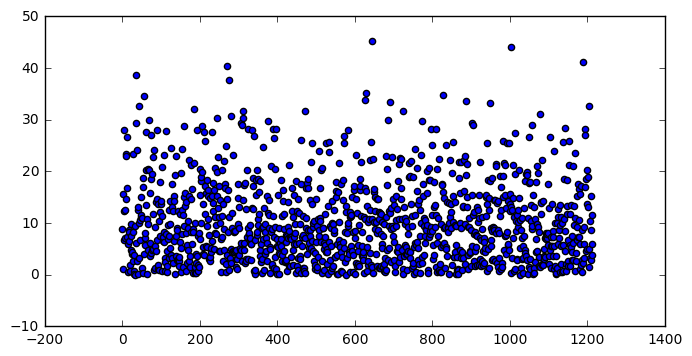

In [19]:
# graph errors over the course of season
deltas = []
for idx, pred in enumerate(lin_regr_predictions):
  actual_score_delta = labels_for_2016_2017[idx]
  deltas.append(abs(pred-actual_score_delta))
print len(deltas)
print len(range(0, len(labels_for_2016_2017)))
plt.figure(figsize=(8,4))
plt.scatter(range(0, len(labels_for_2016_2017)), deltas)

In [20]:
avg_0 = 0
for i in range(len(deltas)):
  avg_0 += deltas[i]
print "Average delta 0 games in: {}".format(avg_0/len(deltas))
avg_400 = 0
for i in range(400, len(deltas)):
  avg_400 += deltas[i]
print "Average delta 400 games in: {}".format(avg_400/(len(deltas)-400))
avg_800 = 0
for i in range(800, len(deltas)):
  avg_800 += deltas[i]
print "Average delta 800 games in: {}".format(avg_800/(len(deltas)-800))
avg_1000 = 0
for i in range(1000, len(deltas)):
  avg_1000 += deltas[i]
print "Average delta 1000 games in: {}".format(avg_1000/(len(deltas)-1000))

Average delta 0 games in: 10.1195255928
Average delta 400 games in: 9.77358319687
Average delta 800 games in: 9.9545942752
Average delta 1000 games in: 9.67561812041


In [21]:
avg_600_800 = 0
for i in range(600, 800):
  avg_600_800 += deltas[i]
print "Average delta between games 600 to 800: {}".format(avg_600_800/200)
avg_800_1000 = 0
for i in range(800, 1000):
  avg_800_1000 += deltas[i]
print "Average delta between games 800 to 1000: {}".format(avg_800_1000/200)
avg_1000_end = 0
for i in range(1000, len(deltas)):
  avg_1000_end += deltas[i]
print "Average delta between games 1000 to end: {}".format(avg_1000_end/(len(deltas) - 1000))

Average delta between games 600 to 800: 10.4003524929
Average delta between games 800 to 1000: 10.2530987608
Average delta between games 1000 to end: 9.67561812041


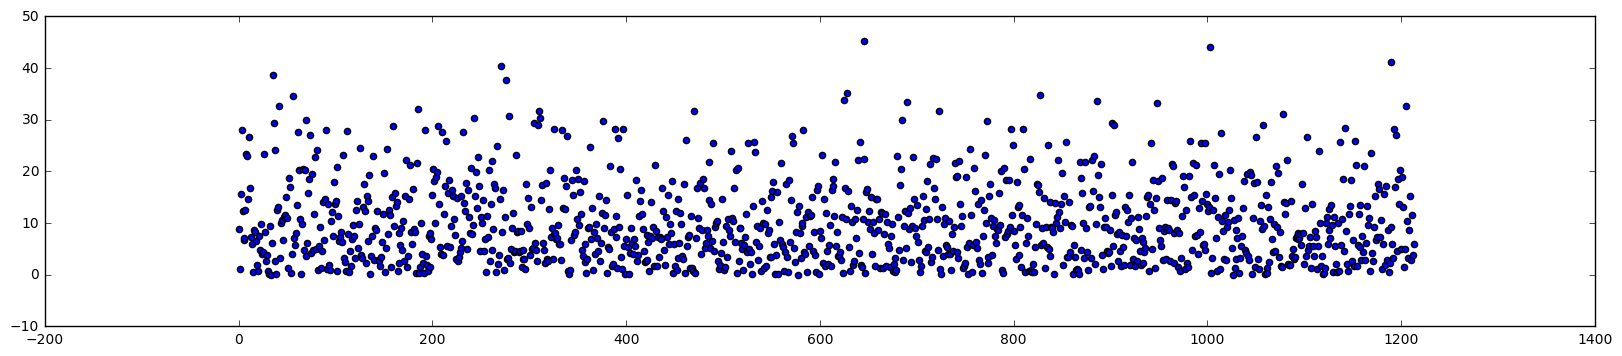

In [22]:
import matplotlib.ticker as mticks

plt.figure(figsize=(20,4))
plt.scatter(range(0, len(labels_for_2016_2017)), deltas)

In [23]:
# Evaluate the classification case, do we at least predict the outcomes correctly?
correct_classifications = 0.
for idx in range(0, len(lin_regr_predictions)):
  pred = lin_regr_predictions[idx]
  actual_score_delta = labels_for_2016_2017[idx]
  # if in the same direction
  if pred * actual_score_delta > 0:
    correct_classifications += 1
print "Classification rate: {}".format(correct_classifications/(len(lin_regr_predictions)))

Classification rate: 0.631795716639


In [24]:
regr_2016_2017.coef_

array([  5.42905255e+12,  -3.37402344e-01,  -4.13618164e+01,
         2.71452627e+12,   4.58862305e-01,   8.45556641e+00,
         2.71452627e+12,  -2.51464844e-01,   4.34472656e+00,
        -1.52107145e+12,  -1.52107145e+12,   1.52107145e+12,
         1.98901367e+00,   1.09725952e-01,   2.04711914e-01,
        -1.10675049e+00,  -9.35058594e-02,  -2.71452627e+12,
         2.56072998e-01,  -3.68286133e+00,   4.03466797e+00,
         4.26635742e+00,   3.84643021e+01,   1.55761719e+00,
        -4.71740723e+00,  -3.06165695e+00,   2.86915561e+01,
        -2.19095969e+01,   1.18478394e+00,   1.00925640e+02,
        -7.76639690e+01,   1.18410107e+03,  -1.97021484e-01,
         1.78751326e+00,   2.70244802e+12,   3.68408203e-01,
         2.10816316e+02,   1.35122401e+12,   3.24096680e-02,
         1.46225240e+01,   1.35122401e+12,  -7.69165039e-01,
        -1.07322474e+01,  -6.83138333e+12,  -6.83138333e+12,
         6.83138333e+12,  -2.78933716e+00,  -2.75360107e-01,
        -4.07234192e-01,

In [25]:
print "R^2: {}".format(regr_2016_2017.score(feature_vectors_for_2000_2016, labels_for_2000_2016))

R^2: 0.156041658259


In [26]:
# Train a multi-layer perceptron
mlp_regr = MLPRegressor(hidden_layer_sizes=3, solver='lbfgs')
mlp_regr.fit(feature_vectors_for_2000_2016, labels_for_2000_2016)
mlp_regr_predictions = mlp_regr.predict(feature_vectors_for_2016_2017)

evaluate(0, mlp_regr_predictions)
print
evaluate(400, mlp_regr_predictions)
print
evaluate(800, mlp_regr_predictions)
print
evaluate(1000, mlp_regr_predictions)

0 games in
Win Percent: 0.503294892916
Loss Percent: 0.496705107084
Bets placed: 1214
Bets not placed: 0

400 games in
Win Percent: 0.52457002457
Loss Percent: 0.47542997543
Bets placed: 814
Bets not placed: 0

800 games in
Win Percent: 0.536231884058
Loss Percent: 0.463768115942
Bets placed: 414
Bets not placed: 0

1000 games in
Win Percent: 0.570093457944
Loss Percent: 0.429906542056
Bets placed: 214
Bets not placed: 0


In [27]:
# Lasso Regression
lasso_reg = linear_model.Lasso(alpha = 0.1)
lasso_reg.fit(feature_vectors_for_2000_2016, labels_for_2000_2016)
lasso_reg_predictions = lasso_reg.predict(feature_vectors_for_2016_2017)

for games_in in [0, 400, 800, 1000]:
  evaluate(games_in, lasso_reg_predictions)
  print

0 games in
Win Percent: 0.523064250412
Loss Percent: 0.476935749588
Bets placed: 1214
Bets not placed: 0

400 games in
Win Percent: 0.539312039312
Loss Percent: 0.460687960688
Bets placed: 814
Bets not placed: 0

800 games in
Win Percent: 0.557971014493
Loss Percent: 0.442028985507
Bets placed: 414
Bets not placed: 0

1000 games in
Win Percent: 0.588785046729
Loss Percent: 0.411214953271
Bets placed: 214
Bets not placed: 0



In [28]:
# Check Fivethirtyeight's win/loss prediction and evaluate their spreads
f = open('prediction/fivethirtyeight_predictions_2016_17')
fte_predictions_2016_17 = eval(f.read())

In [40]:
fte_predictions_reg_season = []
for fte_pred in fte_predictions_2016_17:
  if not fte_pred['playoff']:
    fte_predictions_reg_season.append(fte_pred)
print len(fte_predictions_reg_season)
print "Fivethirtyeight's prediction for the last game of the 2016-17 season:"
print fte_predictions_reg_season[-1]

1230
Fivethirtyeight's prediction for the last game of the 2016-17 season:
{'status': 'post', 'carmelo2_pre': 1397.87549044154, 'score2': 95, 'carmelo_spread': -13.5, 'team1': 'LAC', 'team2': 'SAC', 'carmelo2_post': 1395.38097896773, 'neutral': '!1', 'carmelo1_post': 1640.31618385186, 'score1': 115, 'time_et': '22:30', 'carmelo1_pre': 1637.82167237805, 'date': '2017-04-12', 'carmelo_prob1': 0.9005413202718072, 'playoff': None, 'id': 400900606, 'carmelo_prob2': 0.09945867972819278}


In [43]:
# evaluate 538's win/loss rate
correct_classifications_538 = 0.
for fte_pred in fte_predictions_reg_season:
  score1 = fte_pred['score1']
  score2 = fte_pred['score2']
  win_prob_team1 = fte_pred['carmelo_prob1']
  win_prob_team2 = fte_pred['carmelo_prob2']
  
  if win_prob_team1 > win_prob_team2:
    if score1 > score2:
      correct_classifications_538 += 1
  else:
    if score2 > score1:
      correct_classifications_538 += 1

print "Fivethirtyeight Classification Rate: {}".format(correct_classifications_538/len(fte_predictions_reg_season))

Fivethirtyeight Classification Rate: 0.649593495935
